In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

## Overview

This notebook will use three datasets to investigate confirmed Covid-19 cases, mask usage, and other factors Prince George's County MD. The datasets used include the John Hopkin's Covid Case Count dataset from Kaggle, which can be found at the url below:

 - https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university
 
The New York Times mask usage survey data, which can be found in the following github repo:

 - https://github.com/nytimes/covid-19-data/tree/master/mask-use

As well as the CDC's dataset recording mask mandates by US county:

 - https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i

The notebook will begin by examining mask usage rates, continuing the investigation by creating a model for confirmed cases in the context of mask mandates and vaccine eligibility expansions.

## Data Ingestion, Setup, and Cleaning

Belowk, we will ingest data from a local folder after obtaining it from the sources linked above. We will also specify important key dates, codes, and names to be used during data cleaning as well as later in the analysis.

In [2]:
# Define county/state name, population, and fips_code constants for the analysis

county_name = 'Prince George\'s'
county_state = 'Maryland'
fips_code = 24033
population_2020 = 967201

# Define date all adults (16+) in Maryland became eligbible for vaccine

vaccine_day = np.datetime64('2021-04-06')

### Mask Usage Survey Data

In [3]:
# download and display head of NYT mask use by county dataset

mask_use_by_county = pd.read_csv('data/mask-use-by-county.csv')
mask_use_by_county.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [4]:
# select only Prince George's county through its FIPS code, display
# proportions

mask_use = mask_use_by_county[mask_use_by_county['COUNTYFP'] == fips_code]
mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1208,24033,0.087,0.034,0.064,0.094,0.72


### Mask Mandate Data

In [5]:
# download and display first rows of mask mandate data

mask_mandates = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020' + \
               '_through_August_15__2021_by_County_by_Day.csv')
mask_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [6]:
# select only Prince George's county, display first few rows of data

mandates = mask_mandates[mask_mandates['County_Name'] == county_name + ' County']
mandates['date'] = pd.to_datetime(mandates['date'])
mandates.head()

/var/folders/r0/46tzw5cj2rb7834r_m4kmf_80000gn/T/ipykernel_95667/3261573412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandates['date'] = pd.to_datetime(mandates['date'])


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
321400,MD,Prince George's County,24,33,2020-04-10,2,NaN,NaN,NaN,NaN
321401,MD,Prince George's County,24,33,2020-04-11,2,NaN,NaN,NaN,NaN
321402,MD,Prince George's County,24,33,2020-04-12,2,NaN,NaN,NaN,NaN
321403,MD,Prince George's County,24,33,2020-04-13,2,NaN,NaN,NaN,NaN
321404,MD,Prince George's County,24,33,2020-04-14,2,NaN,NaN,NaN,NaN


### Confirmed Cases Data

In [7]:
# load confirmed cases data from data folder, display first rows

us_confirmed_cases = pd.read_csv('data/johns_hopkins_data/CONVENIENT_us_confirmed_cases.csv')
us_confirmed_cases.head()

/Users/trevornims/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,24

,Province_State,Alabama,Alabama.1,Alabama.2,Alabama.3,Alabama.4,Alabama.5,Alabama.6,Alabama.7,Alabama.8,...,Wyoming.15,Wyoming.16,Wyoming.17,Wyoming.18,Wyoming.19,Wyoming.20,Wyoming.21,Wyoming.22,Wyoming.23,Wyoming.24
0,Admin2,Autauga,Baldwin,Barbour,Bibb,Blount,Bullock,Butler,Calhoun,Chambers,...,Park,Platte,Sheridan,Sublette,Sweetwater,Teton,Uinta,Unassigned,Washakie,Weston
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Visually inspect columns in the state of Maryland, find the alias for
# our county and hard-code it

col_names = np.array(us_confirmed_cases.columns)

county_col_names = [name for name in col_names if name.startswith(county_state)]
us_confirmed_cases[county_col_names]
col_alias = 'Maryland.17'

In [9]:
# Utilize 'col_alias' to select our county's weekly data, rename
# columns and omit first row, change datatypes of both columns
# for plotting, display first rows of cleaned dataset

weekly_cases = us_confirmed_cases[['Province_State', col_alias]]
weekly_cases.drop(index=0, inplace=True)
weekly_cases.rename(mapper={'Province_State' : 'week', 'Maryland.17' : 'cases'}, axis=1, inplace=True)
weekly_cases['week'] = pd.to_datetime(weekly_cases['week'])
weekly_cases['cases'] = pd.to_numeric(weekly_cases['cases'])
weekly_cases.head()

/Users/trevornims/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/trevornims/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/r0/46tzw5cj2rb7834r_m4kmf_80000gn/T/ipykernel_95667/3946814796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,week,cases
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
5,2020-01-27,0.0


In [10]:
# Create array of dates where mask mandates were in effect

dates_with_mask_mandates = np.array(mandates[mandates['Face_Masks_Required_in_Public'] == 'Yes']['date'])

In [11]:
# Check if time series is continous, will print message if not

for i in range(0, len(dates_with_mask_mandates)-1):
    # np.timedelta64(-86400000000000,'ns') is equal to one day - mask mandate data
    # is recorded day-to-day
    if dates_with_mask_mandates[i]-dates_with_mask_mandates[i+1] != np.timedelta64(-86400000000000,'ns'):
        print('Time series not continuous!')
        break

## Visualizations

Now that the data has been processed/cleaned, we can generate a few visualizations that will give better insight into how the data is distributed.

First, we will begin with a simple bar chart laying out the distribution of responses in Prince George's County to the NYT survey question "How often do you wear a mask in public when you expect to be within six feet of another person?"

/Users/trevornims/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


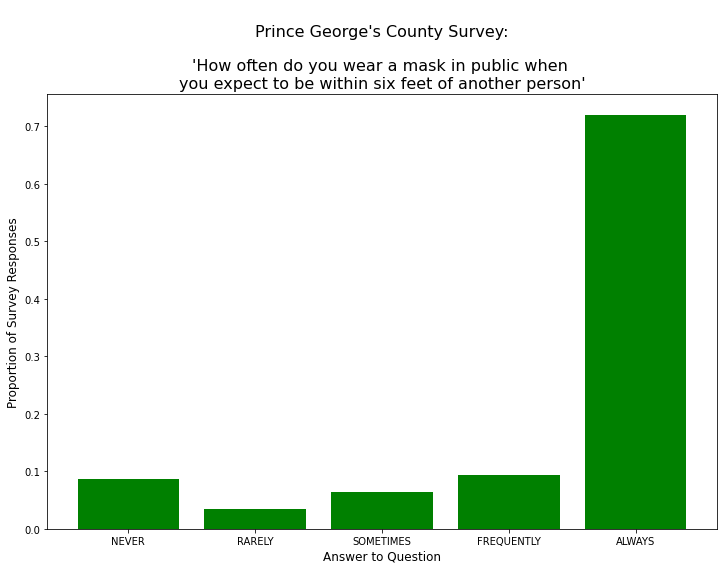

In [12]:
# Plot bar chart of county-resident mask mandate compliance

mask_use.drop(labels='COUNTYFP', axis=1, inplace=True)

proportions = mask_use.iloc[0].values
labels = mask_use.iloc[0].index
x_pos = [i for i, _ in enumerate(proportions)]

fig = plt.figure(figsize=(12, 8))
plt.bar(x_pos, proportions, color='green')
plt.xlabel("Answer to Question", fontsize=12)
plt.ylabel("Proportion of Survey Responses", fontsize=12)
plt.title("\n" + county_name + " County Survey:\n\n'How often do you wear a mask in public\
 when \nyou expect to be within six feet of another person'", fontsize=16)

plt.xticks(x_pos, labels)
plt.savefig('visualizations/Mask_Wearing_Proportions.png', facecolor='w', bbox_inches='tight')

As can be seen above, an overwhelming majority of respondents replied "Always" (upwards of 70%). However, a small, but not insignificant contingent of respondents replied "Never" (almost 10%). While these survey results suggest that following CDC-reccomended mask etiquette was common in Prince George's county, it was not the norm for all.

Next, we'll look at the 7-day rolling average of confirmed cases in Prince George's County, highlighting significant timeframes such as:

    - Dates when mask mandates were in effect (green portion)
    - The date when all adults (16+) in Maryland became eligible for the Covid-19 Vaccine per the governer's website (Vertical Red Line) 

The link to the MD governer's annoucement can be found below:

 - https://governor.maryland.gov/2021/04/05/governor-hogan-announces-accelerated-vaccine-eligibility-schedule-for-all-marylanders/#:~:text=ANNAPOLIS%2C%20MD%E2%80%94Governor%20Larry%20Hogan,vaccinated%20at%20mass%20vaccination%20sites.

    

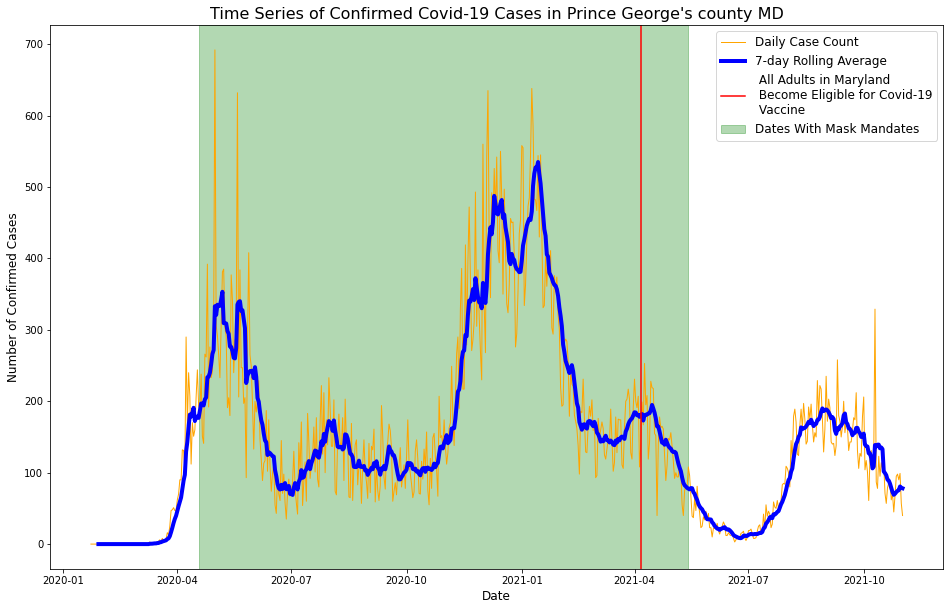

In [13]:
# Plot confirmed cases in Prince George's county over time, including rolling 7-day average
# as well as shaded area highlighting time period when mask mandates were in effect.

fig = plt.figure(figsize=(16, 10))
plt.plot(weekly_cases['week'], weekly_cases['cases'], color='orange', linewidth=1, label='Daily Case Count')
plt.plot(weekly_cases['week'], weekly_cases['cases'].rolling(7).mean(), color='blue', linewidth=4,
        label='7-day Rolling Average')
plt.axvspan(min(dates_with_mask_mandates), max(dates_with_mask_mandates), 
           label="Dates With Mask Mandates",color="green", alpha=0.3)
plt.axvline(vaccine_day, color='red', 
            label=' All Adults in Maryland\n Become Eligible for Covid-19\n Vaccine')
plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Confirmed Cases', fontsize=12)
plt.title('Time Series of Confirmed Covid-19 Cases in Prince George\'s county MD', fontsize=16)
plt.savefig('visualizations/Time_Series_Total.png', facecolor='w')

As can be seen above, the distribution of confirmed cases is highly variable - while some intuitive peaks and valleys in case count can be seen, in general the graph is more descriptive than analytical.

Next, we will perform some minor data alteration to view the case count in the frequency domain, looking at the daily change in Covid-19 cases, as well as training a basic ridge regression model and plotting it.

In [14]:
# Create field denoting the change in number of cases by day

weekly_cases['change_in_number_of_cases'] = weekly_cases['cases'].diff()

/var/folders/r0/46tzw5cj2rb7834r_m4kmf_80000gn/T/ipykernel_95667/1817490266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_cases['change_in_number_of_cases'] = weekly_cases['cases'].diff()


In [15]:
# Create ridge model trained on daily change in number of cases field for all
# time periods, use model to create predictions for all time periods for plotting

X = np.array(weekly_cases['week']).reshape(-1, 1)
y = np.nan_to_num(np.array(weekly_cases['change_in_number_of_cases']).reshape(-1, 1))
model = linear_model.Ridge(alpha=1.0)
model.fit(X, y)

preds = model.predict(X.astype(float))

Text(0.5, 1.0, "Time Series of Daily Change in Confirmed Covid-19 Cases in Prince George's county MD")

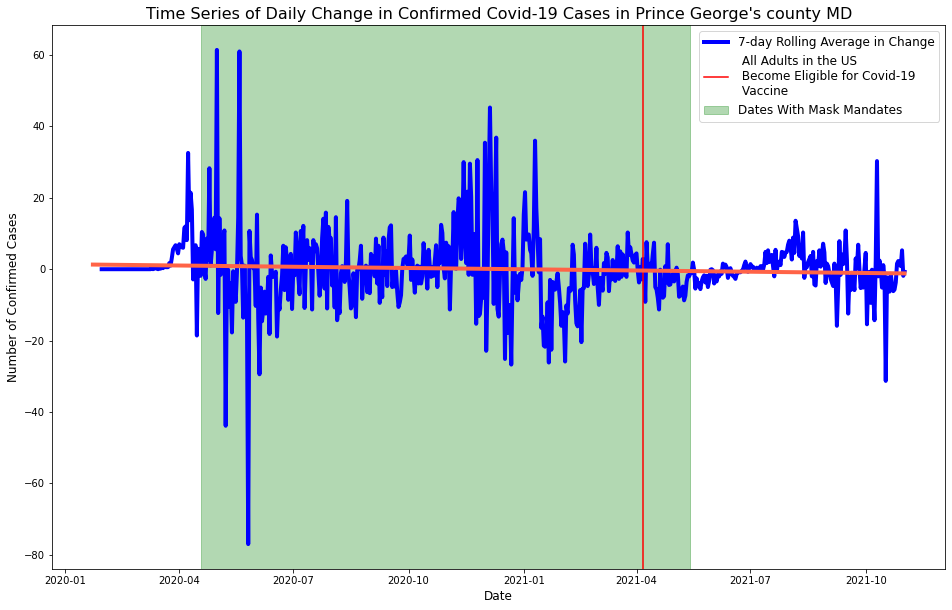

In [16]:
# Plot predictions on 7-day rolling average daily change plot

fig = plt.figure(figsize=(16, 10))
plt.plot(weekly_cases['week'], weekly_cases['change_in_number_of_cases'].rolling(7).mean(), color='blue', linewidth=4,
        label='7-day Rolling Average in Change')
plt.axvspan(min(dates_with_mask_mandates), max(dates_with_mask_mandates), 
           label="Dates With Mask Mandates",color="green", alpha=0.3)
plt.axvline(vaccine_day, color='red', 
            label=' All Adults in the US\n Become Eligible for Covid-19\n Vaccine')
plt.plot(weekly_cases['week'], preds, color='tomato', linewidth=4)
plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Confirmed Cases', fontsize=12)
plt.title('Time Series of Daily Change in Confirmed Covid-19 Cases in Prince George\'s county MD', fontsize=16)

In [17]:
# Examine model coefficients

print(model.coef_)

[[-4.41447691e-17]]


As we can see above, the change in daily number of cases is less variable than the raw confirmed case count data. Even so, this initial ridge regression model does not seem to elicit much insight. While we can confirm that the slope of the line is indeed negative (implying a slow but steady decrease in the change of number of new daily cases over time), we cannot glean much more than that.

To hopefully improve what our linear model can tell us, the next graph will train three separate ridge models on three different timeframes:

 - Pre-mask mandate
 - Post-mask mandate but pre-vaccine
 - Post-vaccine

In [18]:
# Partition dataset into three timeframes, pre-mask mandate, post-mandate and pre-vaccine, and post-vaccine

pre_mandate_data = weekly_cases[weekly_cases['week'] < min(dates_with_mask_mandates)]
pre_vaccine_data = pd.concat([weekly_cases[weekly_cases['week'] < vaccine_day], 
                              pre_mandate_data]).drop_duplicates(keep=False)
post_vaccine_data = pd.concat([weekly_cases, pre_vaccine_data, pre_mandate_data]).drop_duplicates(keep=False)

partitioned_df_list = [pre_mandate_data, pre_vaccine_data, post_vaccine_data]

In [19]:
# Train separate models on each timeframe dataset, create and save model predictions for each timeframe

model_prediction_sets = []
models = []

for df in partitioned_df_list:
    X = np.array(df['week']).reshape(-1, 1)
    y = np.nan_to_num(np.array(df['change_in_number_of_cases']).reshape(-1, 1))
    model = linear_model.Ridge(alpha=1.0)
    model.fit(X, y)
    models.append(model)
    model_prediction_sets.append(model.predict(X.astype(float)))

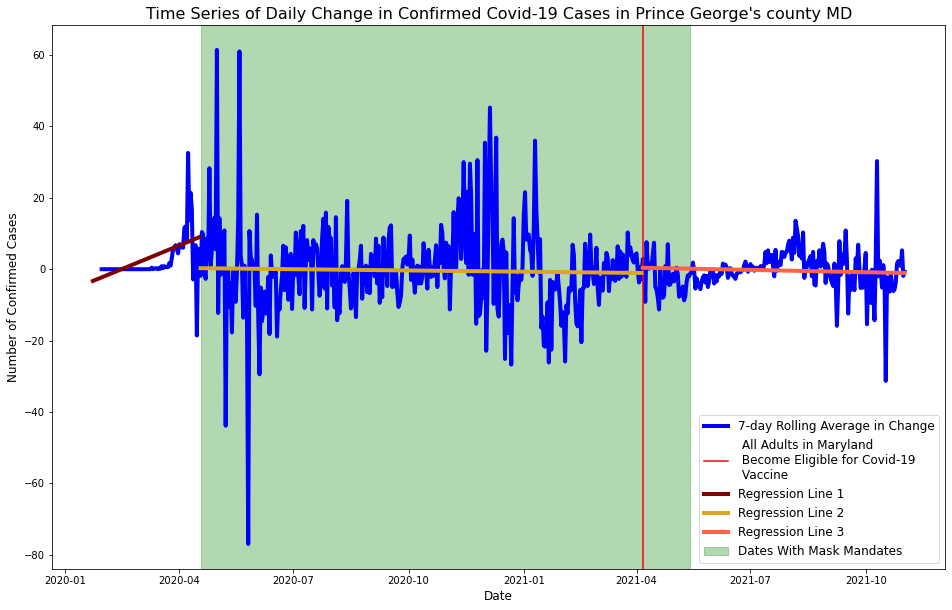

In [20]:
# Plot the three model predictions on 7-day rolling average daily change plot

regression_line_colors = ['maroon', 'goldenrod', 'tomato']

fig = plt.figure(figsize=(16, 10))
plt.plot(weekly_cases['week'], weekly_cases['change_in_number_of_cases'].rolling(7).mean(), color='blue', linewidth=4,
        label='7-day Rolling Average in Change')
plt.axvspan(min(dates_with_mask_mandates), max(dates_with_mask_mandates), 
           label="Dates With Mask Mandates",color="green", alpha=0.3)
plt.axvline(vaccine_day, color='red', 
            label=' All Adults in Maryland\n Become Eligible for Covid-19\n Vaccine')

for i, df in enumerate(partitioned_df_list):
    plt.plot(df['week'], model_prediction_sets[i], color=regression_line_colors[i],
             linewidth=4, label='Regression Line ' + str(i+1))

plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Confirmed Cases', fontsize=12)
plt.title('Time Series of Daily Change in Confirmed Covid-19 Cases in Prince George\'s county MD', fontsize=16)
plt.savefig('visualizations/Time_Series_Change_With_Regression_Lines.png', facecolor='w')

In [21]:
# Print coefficients of the three models in chronological order

for model in models:
    print(model.coef_)

[[1.67023951e-15]]
[[-4.39590706e-17]]
[[-8.14515344e-17]]


As can seen above, the model now has a positive slope in the pre-mask mandate timeframe, but negative slopes both after the mask mandate was put into effect as well as once vaccine eligibility expanded to all adults. 

## Interpretation

While these figures and models certainly suggest the effect of masking and vaccines on the change in daily covid-19 cases, it would be too far to imply anything casual without performing a number of statistical tests.